In [ ]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm

from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.api import OLS, add_constant
import matplotlib.pyplot as plt
%matplotlib inline

# Dataset Exploration

In [ ]:
data= pd.read_csv("final_data_10s.csv",sep=",")

,Time,X_BID,X_BID_VOL,X_ASK,X_ASK_VOL,Y_BID,Y_BID_VOL,Y_ASK,Y_ASK_VOL
0,2019-11-18 08:00:00,106340.0,15.0,106348.0,11.0,105200.0,9.0,105210.0,19.0
1,2019-11-18 08:00:10,106312.0,6.0,106320.0,9.0,105180.0,5.0,105190.0,13.0
2,2019-11-18 08:00:20,106312.0,7.0,106320.0,12.0,105170.0,32.0,105180.0,1.0
3,2019-11-18 08:00:30,106336.0,22.0,106340.0,1.0,105190.0,10.0,105200.0,19.0
4,2019-11-18 08:00:40,106352.0,2.0,106356.0,4.0,105200.0,29.0,105220.0,24.0
...,...,...,...,...,...,...,...,...,...
737734,2020-12-31 09:59:20,109140.0,2.0,109144.0,1.0,107190.0,6.0,107210.0,1.0
737735,2020-12-31 09:59:30,109144.0,1.0,109168.0,21.0,107170.0,1.0,107200.0,1.0
737736,2020-12-31 09:59:40,109120.0,4.0,109144.0,1.0,107170.0,3.0,107230.0,3.0
737737,2020-12-31 09:59:50,109092.0,2.0,109104.0,5.0,107180.0,3.0,107220.0,5.0


First, plot the data to observe the trends.

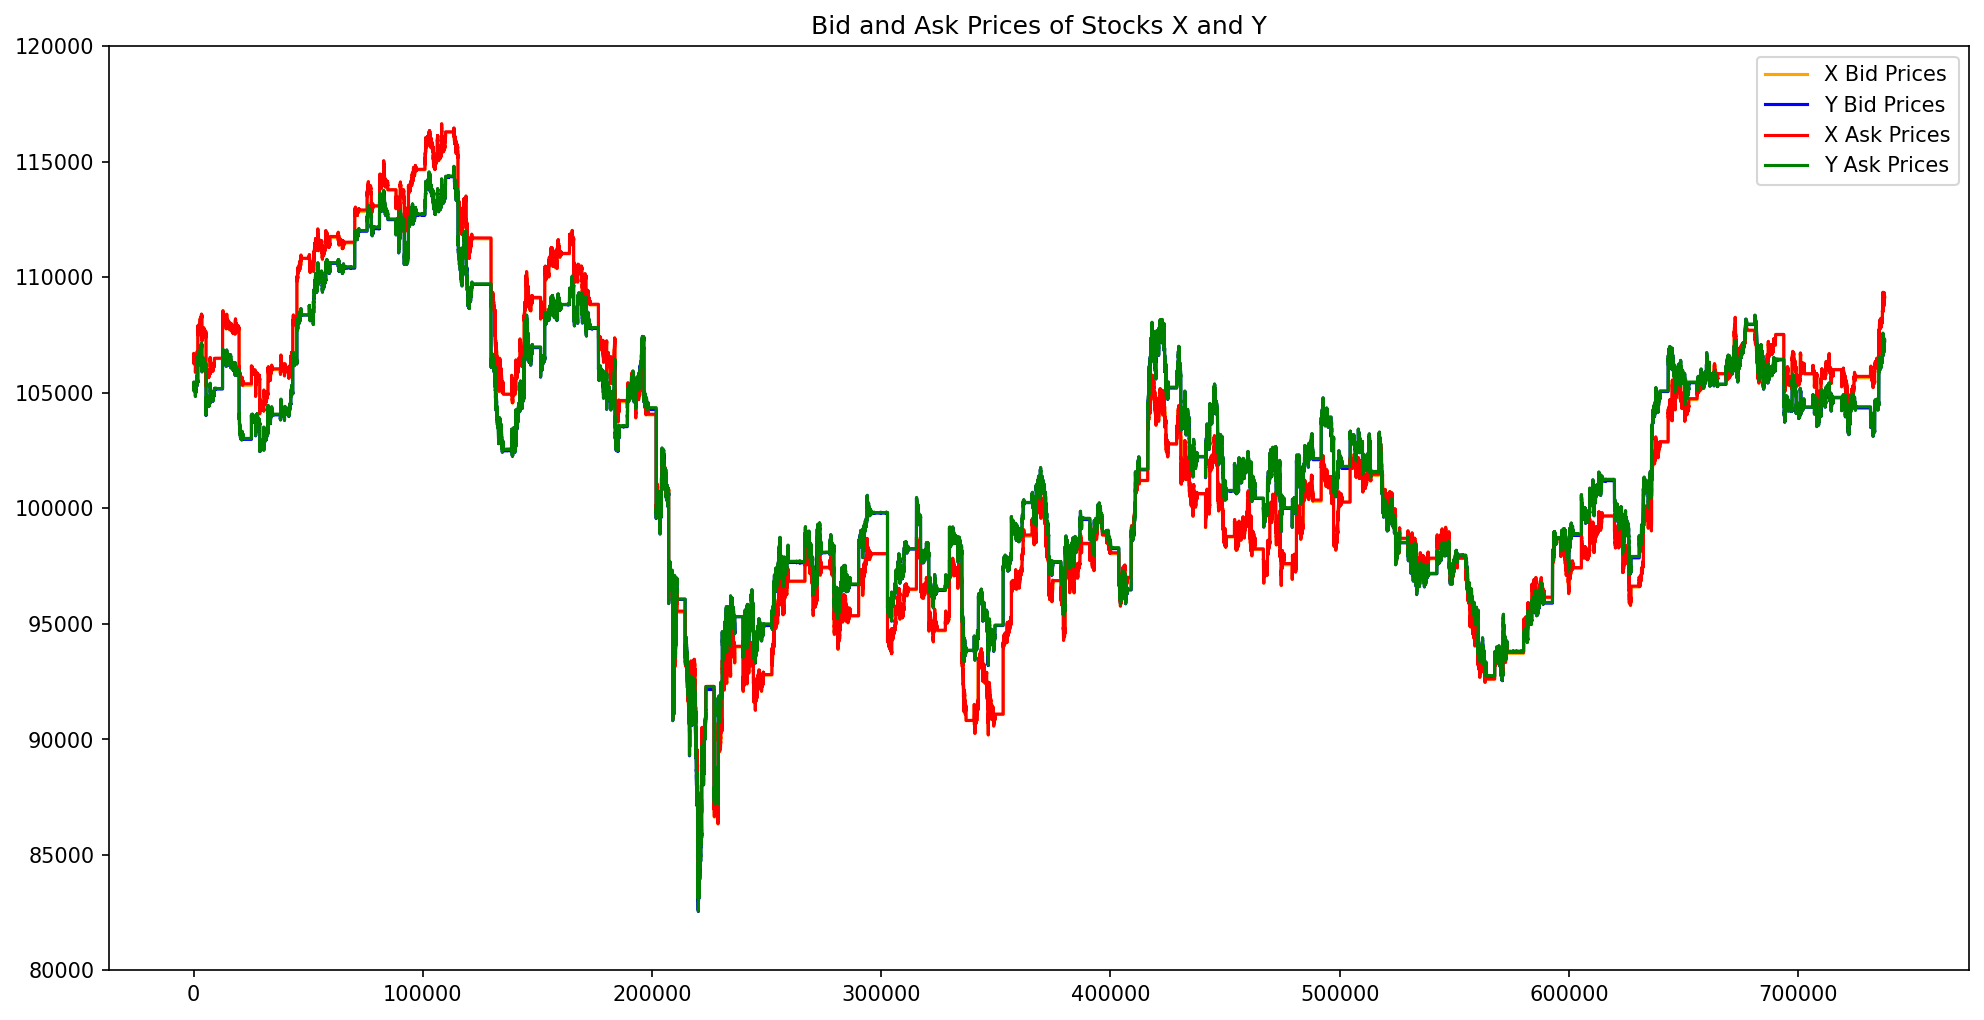

In [ ]:
plt.figure(figsize=(16, 8), dpi=150)

data["X_BID"].plot(label = "X Bid Prices", color = "Orange", ylim=(80000,120000))
data["Y_BID"].plot(label = "Y Bid Prices", color = "Blue")
data["X_ASK"].plot(label = "X Ask Prices", color = "Red")
data["Y_ASK"].plot(label = "Y Ask Prices", color = "Green")

plt.title("Bid and Ask Prices of X and Y")
plt.legend(loc="upper right")

plt.show()

This is very interesting. Firstly, the plotted ask prices for both x and y has overlapped with the bid prices, which indicates the bid-ask spread is small compared to the market price changes. The data does not exhibit strong periodic or seasonality behaviours. 

Pairs trading is heavily based on the idea of finding two historically cointegrated securities, locate the times where the price of the securities diverges and utilise on this opportunity by constructing a market neutral portfolio, and evetually gain profit when the prices of the securities converge back.

After many research, commerically there are two important aspects when considering pairs trading:

1. Stationarity. We want the security prices to be consistent and more predictable so we have more confidence that the prices will always converge to some mean value.

Does the provided data reflect stationarity? It is definitely close, as it is evident that the price movement overtime is somewhat centered. However, the fluctuations are definitely big. I will implement the stationarity tests later, and talk about the second property.

2. Cointegration. Cointegration is a measure of linkage between the financial securities; how close are the price movements of the two financial securities. This is the most crucial measurement, as we definitely want the price of the pair to converge frequently so we can utilise on the divergence opportunities. 

Visually from the diagram, I can definitely see that the price movement of x and y follows a very close trend; however, I observe that in the first 200000 measures, the price of X is often higher; yet in 200000-500000 measures, the price of y is relatively higher; these differences are actually quite significant. Big change in price differences is not a good idea in pairs trading.

I will evaluate on these areas further; for now, let's have a look at the bid-ask spread. 

### Bid-Ask Spread

Let's graph the bid ask spread to mainly observe how liquid is the market. 

<Axes: title={'center': 'The bid ask spread of stock X'}>

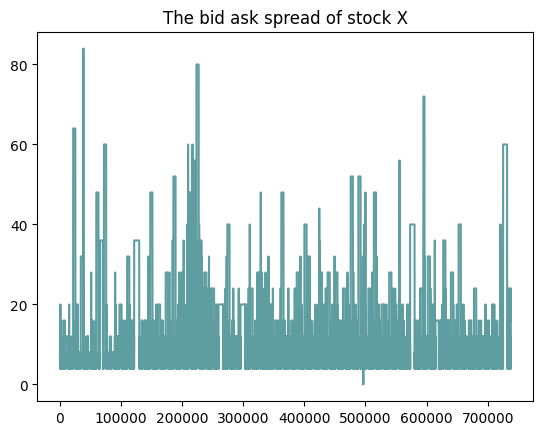

In [ ]:
data["BA_Spread_X"] = data["X_ASK"] - data["X_BID"]

data["BA_Spread_X"].plot(title = "The bid ask spread of X", color = "cadetblue")

<Axes: title={'center': 'The bid ask spread of stock Y'}>

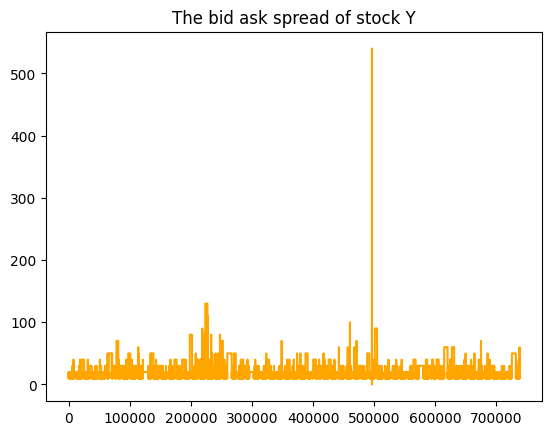

In [ ]:
data["BA_Spread_Y"]= data["Y_ASK"] - data["Y_BID"]

data["BA_Spread_Y"].plot(title = "The bid ask spread of Y", color = "Orange")

Considering the market prices of both X and Y and very high, these bid-ask spread does look very decent and indicates a thin market. The spread of X is relatively smaller than that of Y, but both of them mainly bounded with 150. There is one outlier in the bid-ask spread of Y, which reached 540; we can solve this problem either by removing the outlier, or calculate the middle price between the bid and ask.  

Overall, the ba-spread did not seem to have a big impact. There shall be sufficient market supply and demand and most of the times, which corresponds to the fact that the data is coming from top level market depth. 

### Graphing the mid prices

Since the bid ask spread are mostly thin, we graph the middle price between the bid and ask to analyse the trends and perform calculations. 

In [ ]:
data["X_MID"] = (data["X_ASK"] + data["X_BID"])/2
data["Y_MID"] = (data["Y_ASK"] + data["Y_BID"])/2

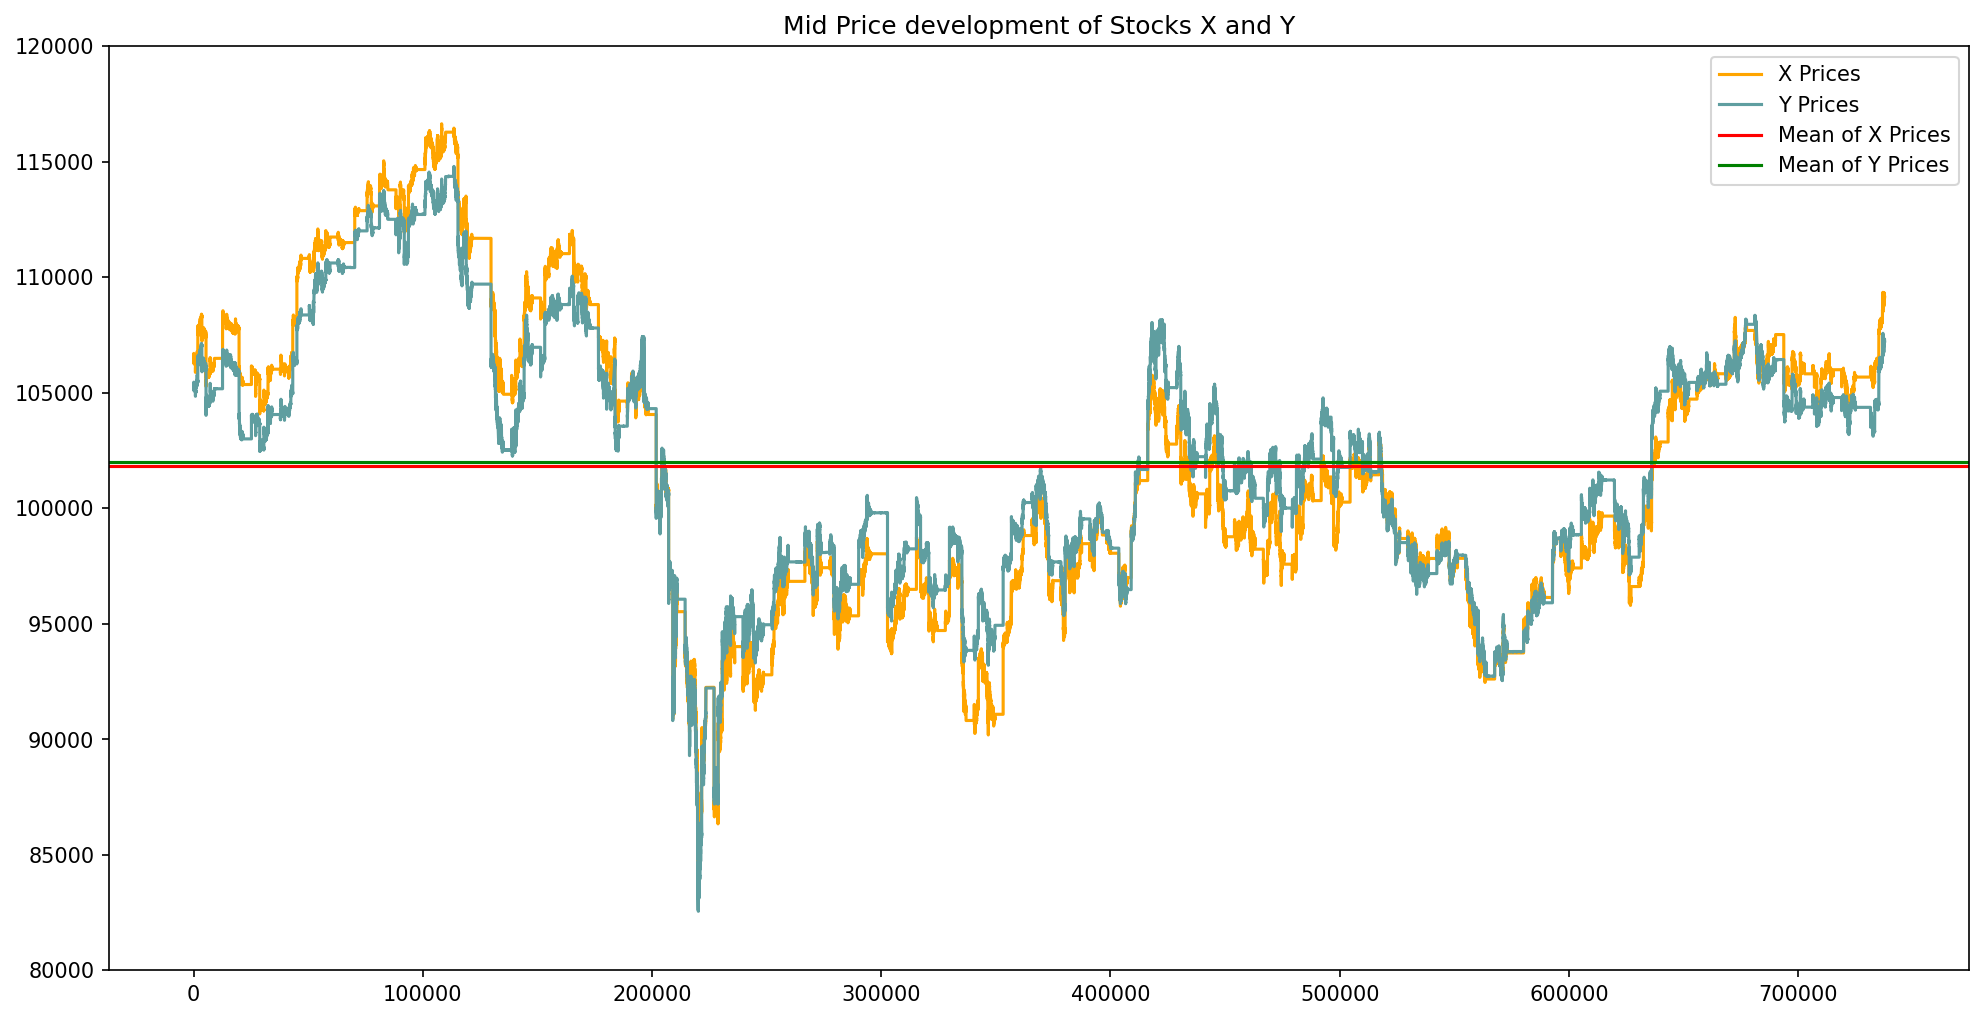

In [ ]:
plt.figure(figsize=(16, 8), dpi=150)

data["X_MID"].plot(label = "X Prices", color = "Orange", ylim=(80000,120000))
data["Y_MID"].plot(label = "Y Prices", color = "cadetblue")
plt.axhline(y=data["X_MID"].mean(), label="Mean of X Prices", color="Red")
plt.axhline(y=data["Y_MID"].mean(), label="Mean of Y Prices", color="Green")

plt.title("Mid Price development of X and Y")
plt.legend(loc="upper right")

plt.show()

### Stationarity & Cointegration

Here, I use the most standard and common set of tests for stationarity and Cointegration. That is, the Augemented Dickey Fuller test to test for the existance of a unit root in the autoregression time model, thus implying the stationarity. If neither X and Y are stationary, I follow the two-step Engle Granger test to check if the residuals between X and Y are stationary i.e. cointegrated. 

I have researched on different methods and the selection of tests is very wide; for example, the KPSS test can also be used to test for stationary, which is somewhat similar to a hypothesese reverted ADF test but considers a deterministic serial trend; in addition, many brokers use the hurst exponent, which measures the long term memory of the time series and allows to locate the mean reversed pairs. However, I only used the two-step Engle Granger test for two reasons:

1. Most of these measures are used in selecting pairs. However, given I already have two securities x and y picked, I only use these measures as an indication of what two expect.
2. Given the assessment timeframe I have not fully understand how the Hurst Exponent algorithm works. Sadly.

In [ ]:
# Perform the ADF test on the mid prices of X and Y.
# Given the price series are very high in value and the changes are quite large, take the log of the data
x_adf = adfuller(np.log(data["X_MID"]))
y_adf = adfuller(np.log(data["Y_MID"]))
# Perform the Engle-Granger Test
coint_score, coint_pvalue, _ = coint(np.log(data["X_MID"]), np.log(data["Y_MID"]))

In [ ]:
print("The p_value of ADF test on X is ", x_adf[1])
print("The p_value of ADF test on Y is ", y_adf[1])

The p_value of ADF test on X is  0.3429305279064081
The p_value of ADF test on Y is  0.16699133225159535


We see both p-values are quite high, which indicates we cannot reject the NULL hypothesis and both X and Y are likely non-stationary.

In [ ]:
print("The pvalue of the Engle-Granger test is ", coint_pvalue)

The pvalue of the Engle-Granger test is  0.09785915050718658


The p-value for the Cointegration test is around 10%. This indicates some cointegration between X and Y, however, not very strong.

### Bid Ask Volumes

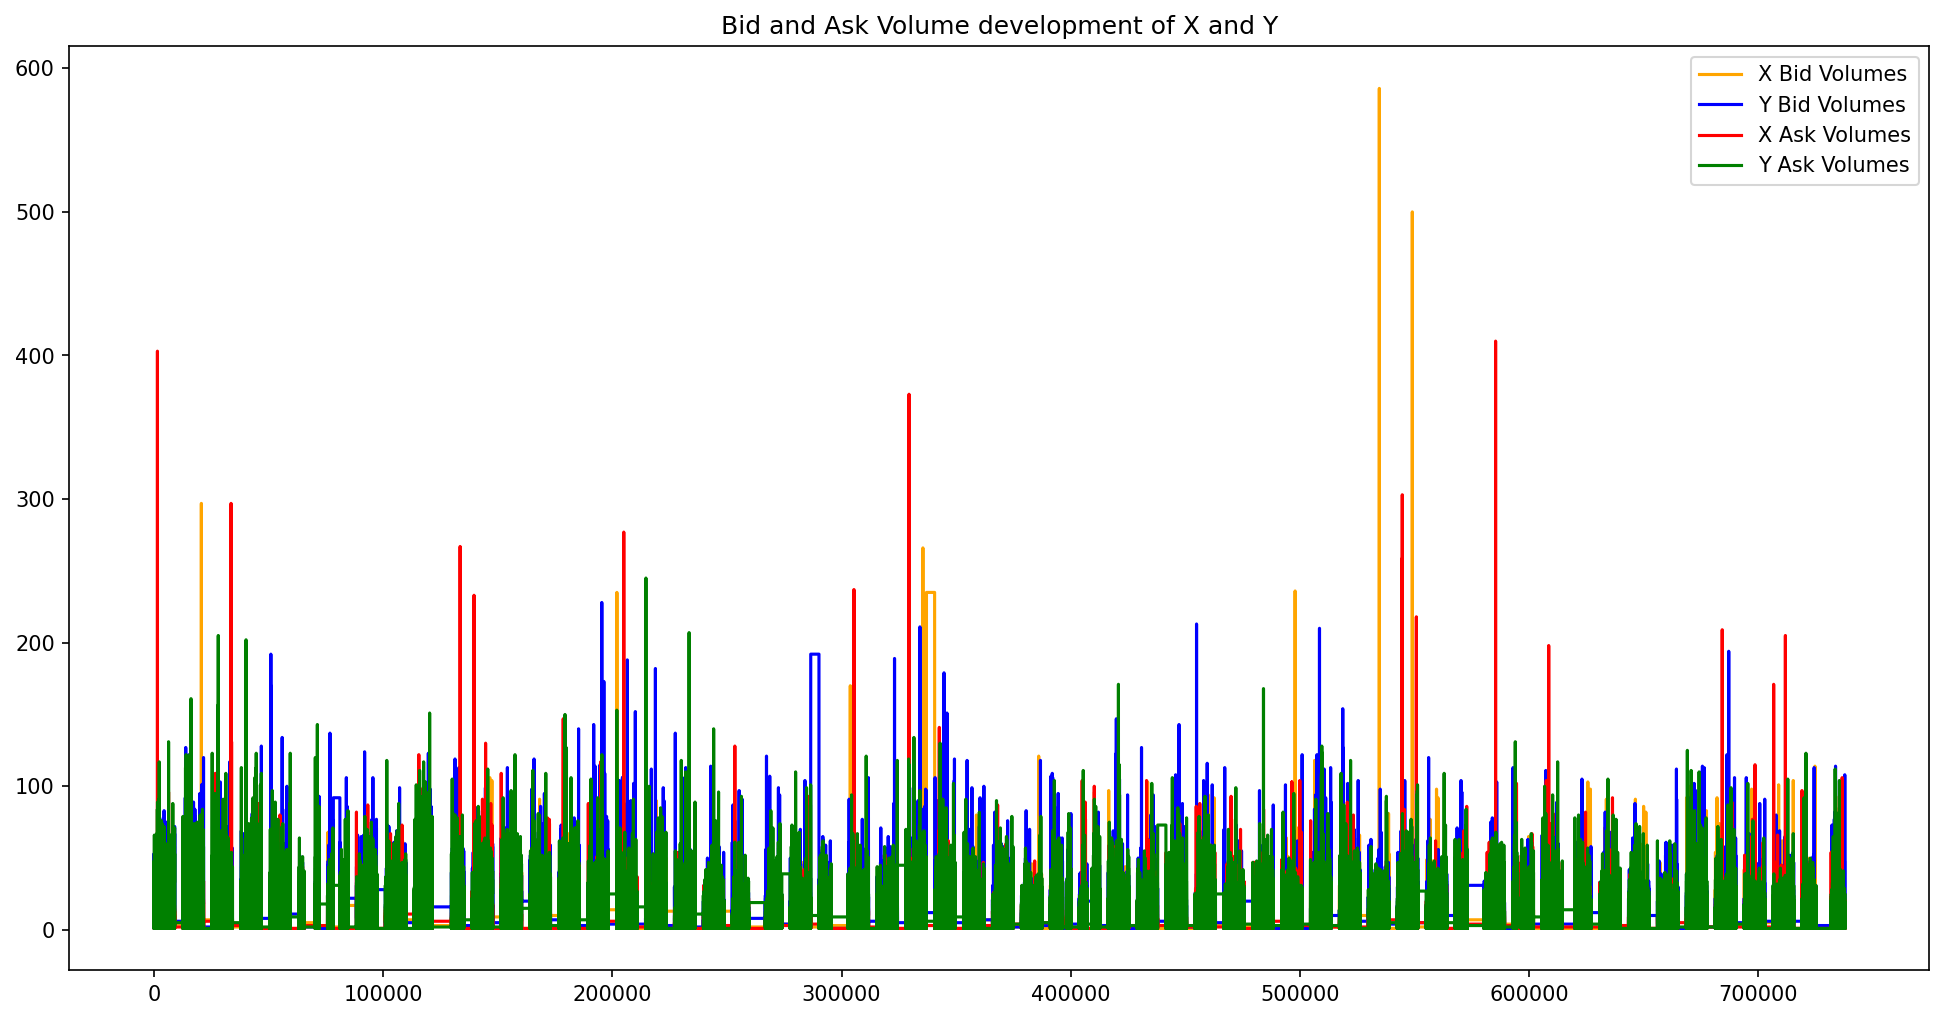

In [ ]:
plt.figure(figsize=(16, 8), dpi=150)

data["X_BID_VOL"].plot(label = "X Bid Volumes", color = "Orange")
data["Y_BID_VOL"].plot(label = "Y Bid Volumes", color = "Blue")
data["X_ASK_VOL"].plot(label = "X Ask Volumes", color = "Red")
data["Y_ASK_VOL"].plot(label = "Y Ask Volumes", color = "Green")

plt.title("Bid and Ask Volume development of X and Y")
plt.legend(loc="upper right")

plt.show()

After plotting the bid ask volume, it is somewhat evident that the market volumes of X and relatively higher than the market volumes of Y. Let's plot the bid-ask volume ratio:

The mean ratio is  2.041119275743176


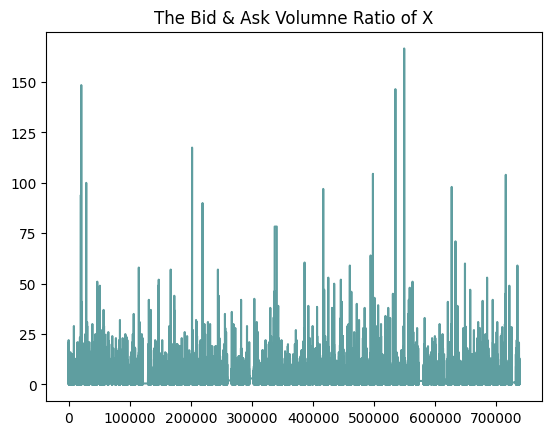

In [ ]:
data["BA_Vol_Ratio_X"] = data["X_BID_VOL"]/data["X_ASK_VOL"]

data["BA_Vol_Ratio_X"].plot(title="The Bid & Ask Volumne Ratio of X", color="cadetblue")

print("The mean ratio is ", data["BA_Vol_Ratio_X"].mean())


This ratio is consistently larger than 1 with mean of 2. Hence there is certainly more market bid/demand at the majority of times.

The mean ratio is  2.3847963593807973


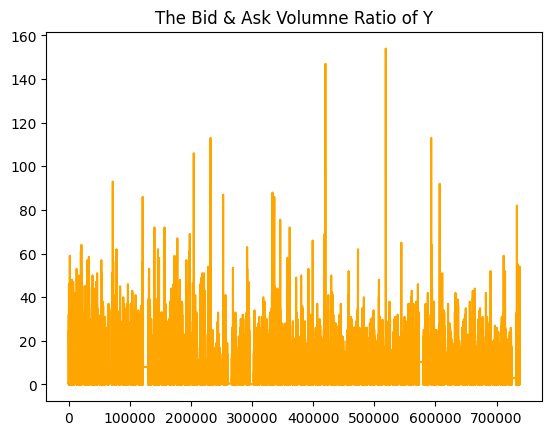

In [ ]:
data["BA_Vol_Ratio_Y"] = data["Y_BID_VOL"]/data["Y_ASK_VOL"]

data["BA_Vol_Ratio_Y"].plot(title="The Bid & Ask Volumne Ratio of Y", color="orange")

print("The mean ratio is ", data["BA_Vol_Ratio_Y"].mean())

Similar trends exist for Y. Hence, in general, the market has more buying/bidding volumes than selling/asking volumes.

From our data analysis, we conclude the following:

- There are some cointegration between the price developments of X and Y, however, not very strong. When considering a pair trading strategy, one shall try to be more conservative.

- The bid volumes has always been relatively larger than the ask volumes. This indicates that it will always be easy to short securities, but buying back could be more challenging.

- There are no obvious periodic trends. The price movements with regards to the mean are quite large.

# Trading Strategy

In [ ]:
# First, perform a 80-20 split oon the training and testing data.
bound = int(np.floor(len(data.index)*0.8))
train_data = data.iloc[:bound]
test_data = data[bound:]

### Pricing Signals

In selecting signals, let's first look at the difference between the X and Y mid prices in the training data.

<Axes: title={'center': 'Price Difference between X and Y'}>

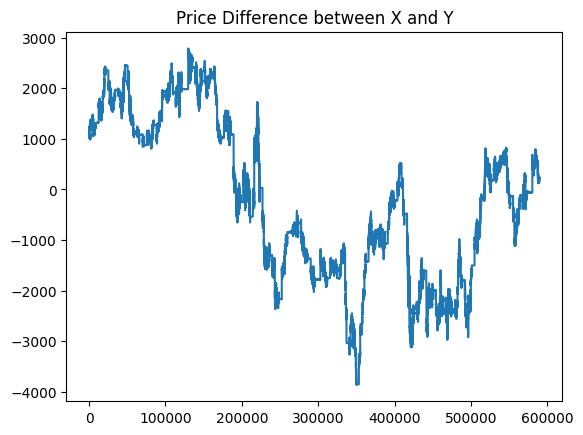

In [ ]:
(train_data["X_MID"] - train_data["Y_MID"]).plot(title = "Price Difference between X and Y")

These differences are relatively small, compared to the price of the securities; however, they do fluctuate quite heavily. Using a price ratio might create too small of a difference given how high the X Y prices are, and I choose to use the spread as the primary pricing signal. Therefore, I would use a OLS regression between X and Y, and find the residuals to be the spread.

One worrysome thing is if the relationship between X and Y can actually be modelled linearly, despite some residuals are expected and acceptable. Plot and see:

Text(0.5, 1.0, 'Price relationship between X and Y')

<Figure size 2400x1200 with 0 Axes>

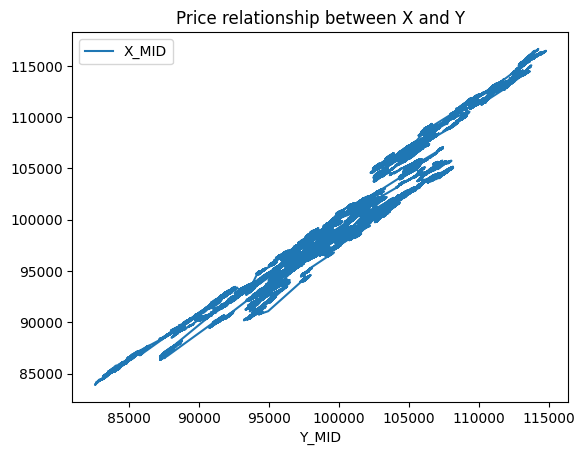

In [ ]:
plt.figure(figsize=(16, 8), dpi=150)
train_data.plot(x = "Y_MID", y = "X_MID")
plt.title("Price relationship between X and Y")

This seems linear; therefore, let's implement the OLS and calculate the hedge ratio, as well as the residuals/spread.

In [ ]:
# alculate the OLS between X and Y
long_run_ols = OLS((train_data["X_MID"]), add_constant((train_data["Y_MID"])))
long_run_ols_fit = long_run_ols.fit()
    
c_train, beta_train = long_run_ols_fit.params
spread_train = long_run_ols_fit.resid


In [ ]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

Text(0.5, 1.0, 'The Z Score progression for train data')

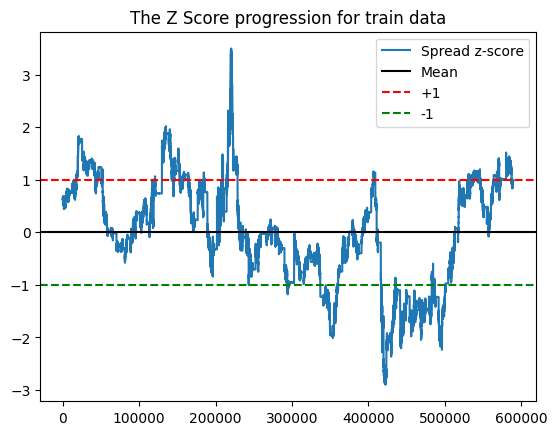

In [ ]:
# Normalise the spread
zscore_train = zscore(spread_train)
zscore_train.plot()
plt.axhline(zscore(spread_train).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1'])
plt.title("The Z Score progression for train data")

The z_score seems like a good trading signal, as there are quite a few fluctuations which may expose some trading opportunities. However, these trading signals seemed less stationary, and has shown a sharp decreasing trend from 250000-500000 counts. 

In addition, since each data is in 10 second snapshots, convert them into 15 min averages, that is, the avergae of 90 snapshots. 500000+ consecutive snapshots is way to much trading signals to analyse.

In [ ]:
# Extract training data into quarters and calculate 15 min average z scores.
zscore_train_avg = zscore_train.groupby(zscore_train.index//90).mean()
train_data_quarters = train_data.iloc[::90]

### Trading strategy

The brief idea from me is to first implement a  simple, rookie strategy :( of using a z-score threshold. Obviously, when the z-score is above the threshold, it is a signal that X (used as the y variable in OLS) has been overpriced, so short X and long Y; whereas when the z-score is below the threshold, long X and short Y.

The first important question that comes to mind is how much to trade given we received a trading signal. Since pairs trading grows in the belief that the prices of X and Y will evetually converge back yet X and Y are not strongly cointegrated, I play a safe option of imposing a smaller volume limit of 5 on both short and long in each trading period. This is the volume that can commonly be satisfied in the given market; or if the market available volume is sometimes below 5, we trade with respect to the available amount. 

Secondly, I would use a linspace to test different thresholds. Given the data is not strongly cointegrated, I would use a relatively higher threshold, such as range(1.5, 3).

So the skeleton of this simple strategy would be:
1. Receive divergence signal
2. Trade up to 5 volumes each security (But not 5 each, taking into account of the hedge ratio) each time the signal is received
3. Sell/buy back the portfolio towards the (0,0) position as much as possible once the divergence signal is gone.



In [498]:
## We test a linspace of thresholds to find the best one in the training data. 
# threshold_lb is the lower bound, thresold_ub is the upper bound, and nthreshold is the number of thresholds wish to be tested.
# if nthreshold is set to 1, then we only test with regards to one threshold
# limit is the trading volume limit 
def trading_positions(market_data, beta, avg_zscore, threshold_lb, threshold_ub, nthreshold, limit):
    
    # Dict to record the trading positions of a specific threshold. threshold value as key
    positions_x = {}
    positions_y = {}

    if nthreshold == 1:
        linspace = [threshold_lb]
    else:
        linspace = np.linspace(threshold_lb, threshold_ub, nthreshold)
    
    for threshold in linspace:
        
        current_name = threshold
        current_position_x = 0
        current_position_y = 0
    
        positions_x[current_name] = []
        positions_y[current_name] = []
    
        for i in range(len(avg_zscore.index)):
            x_bid, x_ask, y_bid, y_ask, x_bid_vol, x_ask_vol, y_bid_vol, y_ask_vol = market_data[["X_BID", "X_ASK", "Y_BID", "Y_ASK", "X_BID_VOL", "X_ASK_VOL", "Y_BID_VOL", "Y_ASK_VOL"]].iloc[i]
            zscore = avg_zscore.iloc[i]
            
            if zscore > threshold: # short X, long Y, X is our main source of profit
                # adjust the hedge ratio with regards to the buying and selling prices
                hedge_ratio = beta * x_bid / y_ask
            
                #max amounts of x can be traded is
                tradable_x = min(limit, x_bid_vol)
                #max amounts of y can be traded is 
                tradable_y = min(limit, y_ask_vol)
                #so in total, the max tradable amount of x is
                max_tradable_x = np.floor(min(tradable_x, tradable_y*hedge_ratio))
                max_tradable_y = np.floor(max_tradable_x/hedge_ratio)
                
                current_position_x = current_position_x - max_tradable_x
                #therefore, the max tradable amount of y is
                current_position_y = current_position_y + max_tradable_y
        
            elif zscore < -threshold: # long x, short y
                hedge_ratio = beta * x_ask/y_bid
            
                tradable_x = min(limit, x_ask_vol)
                tradable_y = min(limit, y_bid_vol)
                    
                max_tradable_y = np.floor(min(tradable_y, tradable_x/hedge_ratio))
                max_tradable_x = np.floor(max_tradable_y*hedge_ratio)
            
                current_position_x = current_position_x + max_tradable_x
                #therefore, the max tradable amount of y is
                current_position_y = current_position_y - max_tradable_y
                
            else: #try to adjust the position to 0 as much as possible
                if current_position_x > 0:
                    current_position_x = current_position_x - min(x_bid_vol, current_position_x)
                    current_position_y = current_position_y + min(y_ask_vol, -1*current_position_y)   
                elif current_position_x < 0:
                    current_position_x = current_position_x + min(x_ask_vol, -1*current_position_x)
                    current_position_y = current_position_y - min(y_bid_vol, current_position_y)
               
            positions_x[current_name].append(current_position_x)
            positions_y[current_name].append(current_position_y)    
    
    return [positions_x,positions_y]
            

            
            
            
        
     

In [499]:
train_positions = trading_positions(train_data_quarters,beta_train, zscore_train_avg, 1.5, 3, 20, 5)

In [501]:
# Next, calculate the profit
def calculate_pnl(positions_x, positions_y, market_data, threshold_lb, threshold_ub, nthreshold):
    
    pnl_records = {} #dict to record pnl with regard to each threshold as key.
    
    for i in range(nthreshold):
        
        if nthreshold == 1:
            threshold = threshold_lb
        else:
            thresholds = np.linspace(threshold_lb, threshold_ub, nthreshold)
            threshold = thresholds[i]
        
        pnl_records[threshold] = []
        position_x = positions_x[threshold]
        position_y = positions_y[threshold]
        pnl = 0
        
        for j in range(1,len(position_x)):
            
            #determine the amount of x and y traded during the last quarter
            x_traded = position_x[j] - position_x[j-1]
            y_traded = position_y[j] - position_y[j-1]
            #execute the trade using the current market prices
            
            if x_traded > 0: # x has been the long asset. so y is the short asset
                pnl = pnl - x_traded*market_data["X_ASK"].iloc[j] - y_traded*market_data["Y_BID"].iloc[j]
            elif x_traded < 0: # short x, long y
                pnl = pnl - x_traded*market_data["X_BID"].iloc[j] - y_traded*market_data["Y_ASK"].iloc[j]
                
            pnl_records[threshold].append(pnl)
    
    return pnl_records

In [502]:
train_pnl = calculate_pnl(train_positions[0],train_positions[1],train_data_quarters, 1.5, 3, 20)
#train_pnl = pd.DataFrame(list(train_pnl.items()))
#print(train_pnl)

Text(0.5, 1.0, 'Profits of threshold using different strategies in train data')

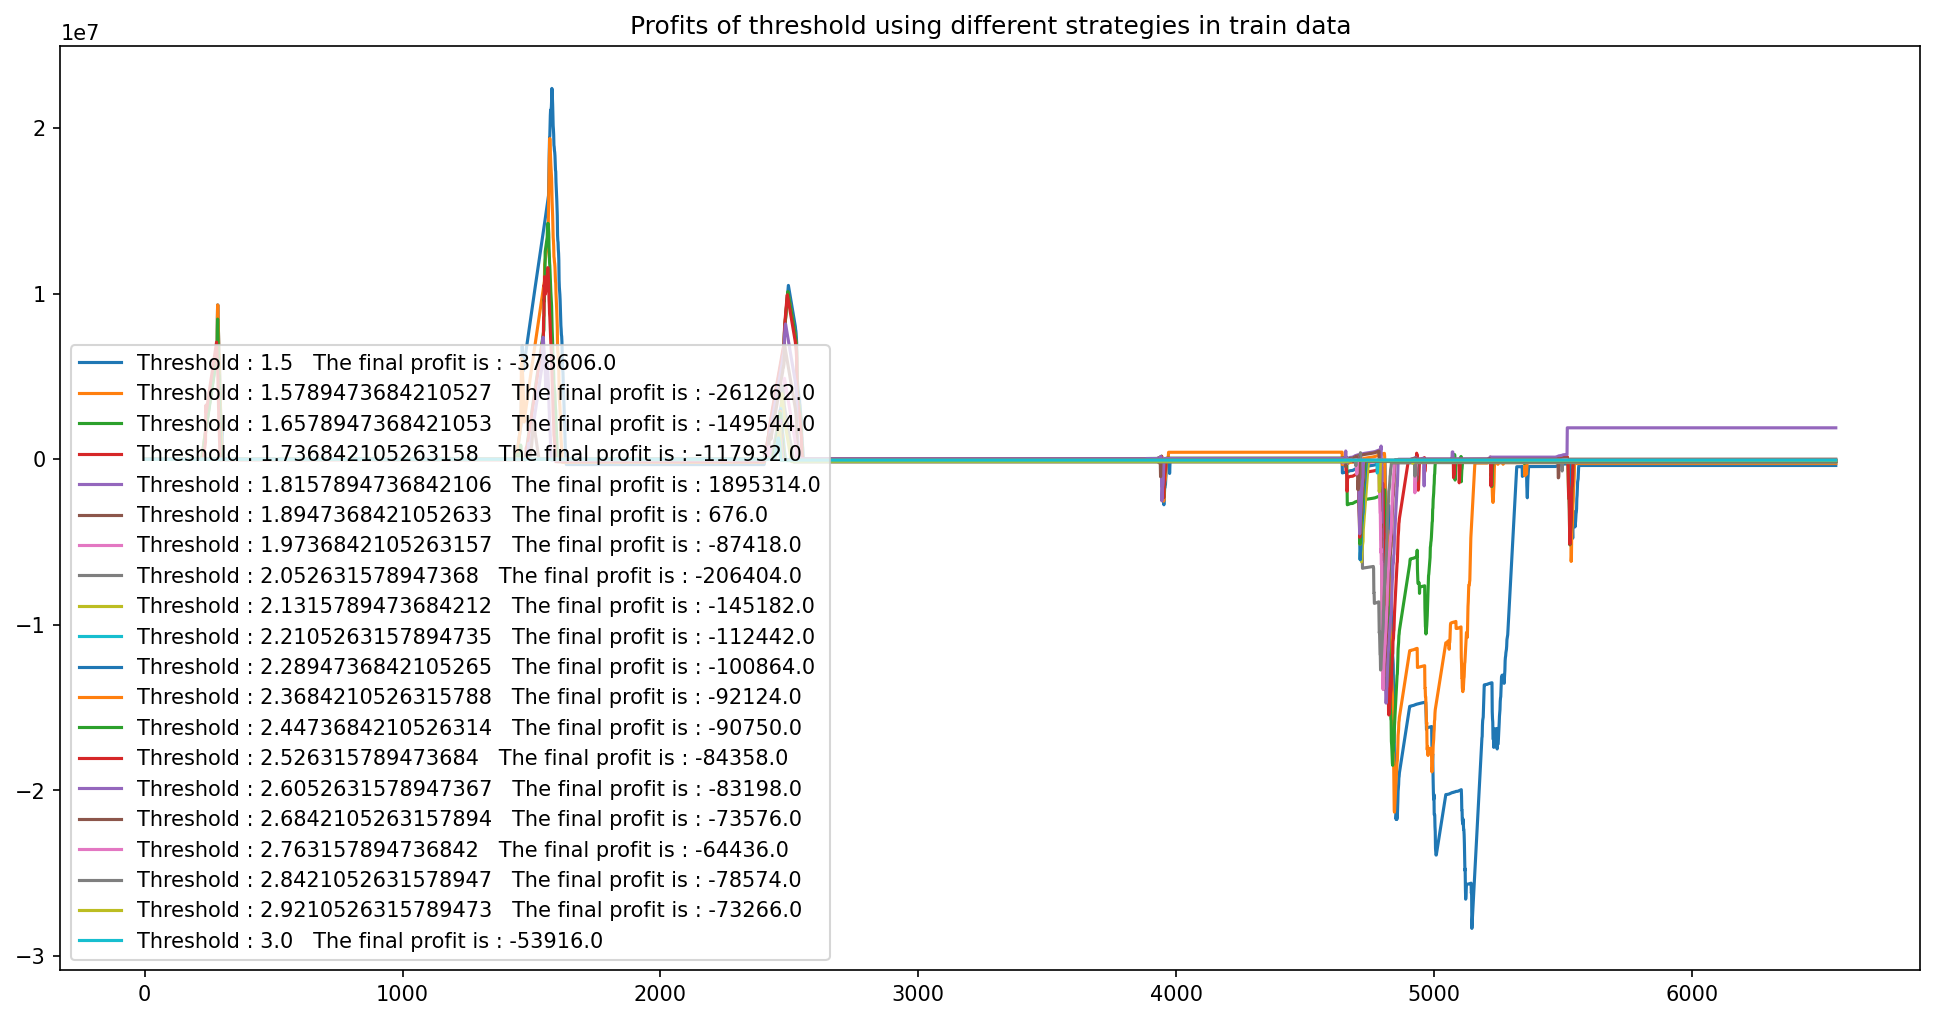

In [505]:
## Plot the profit curve of some thresholds
plt.figure(figsize=(16, 8), dpi=150)
for threshold in train_pnl.keys():
    plt.plot(range(1, len(train_pnl[1.5])+1), train_pnl[threshold], label = "Threshold : "+ str(threshold) + "   The final profit is : " + str(train_pnl[threshold][-1]))
plt.legend(loc = "lower left")
plt.title("Profits of threshold using different strategies in train data")

We can see that overall, the strategy is not performing very well. Most of the strategies ends up losing money, however, the losses are not very big that are mostly price of one or two units of each securities. 

Let's first test the performance of this strategy, and move on to some improvements.

Out of the 20 thresholds tested, only the 1.8157 threshold peaked. Whilst it are no gurantee that the same threshold will perform well in the test data, it is our best bet from the training data.

In [ ]:
# Find the parameters and zscores for the test data.
long_run_ols_test = OLS((test_data["X_MID"]), add_constant((test_data["Y_MID"])))
long_run_ols_fit_test = long_run_ols_test.fit()
    
c_test, beta_test = long_run_ols_fit_test.params
spread_test = long_run_ols_fit_test.resid

# Generate trading signals
zscore_test = zscore(spread_test)
zscore_test_avg = zscore_test.groupby(zscore_test.index//90).mean()
test_data_quarters = test_data.iloc[::90]
#add a tail
test_data_quarters = pd.concat([test_data_quarters, test_data.tail(1)])

In [506]:
# Determine trading strategy
test_positions = trading_positions(test_data_quarters, beta_test, zscore_test_avg, 1.8, 1.8, 1, 5)
# Calculate profit
test_pnl = calculate_pnl(test_positions[0], test_positions[1], test_data_quarters, 1.8, 1.8, 1)
# print("The final profit of the strategy in the test data is", list(test_pnl.values()))

Text(0.5, 1.0, 'PnL development of trading strategy in test data')

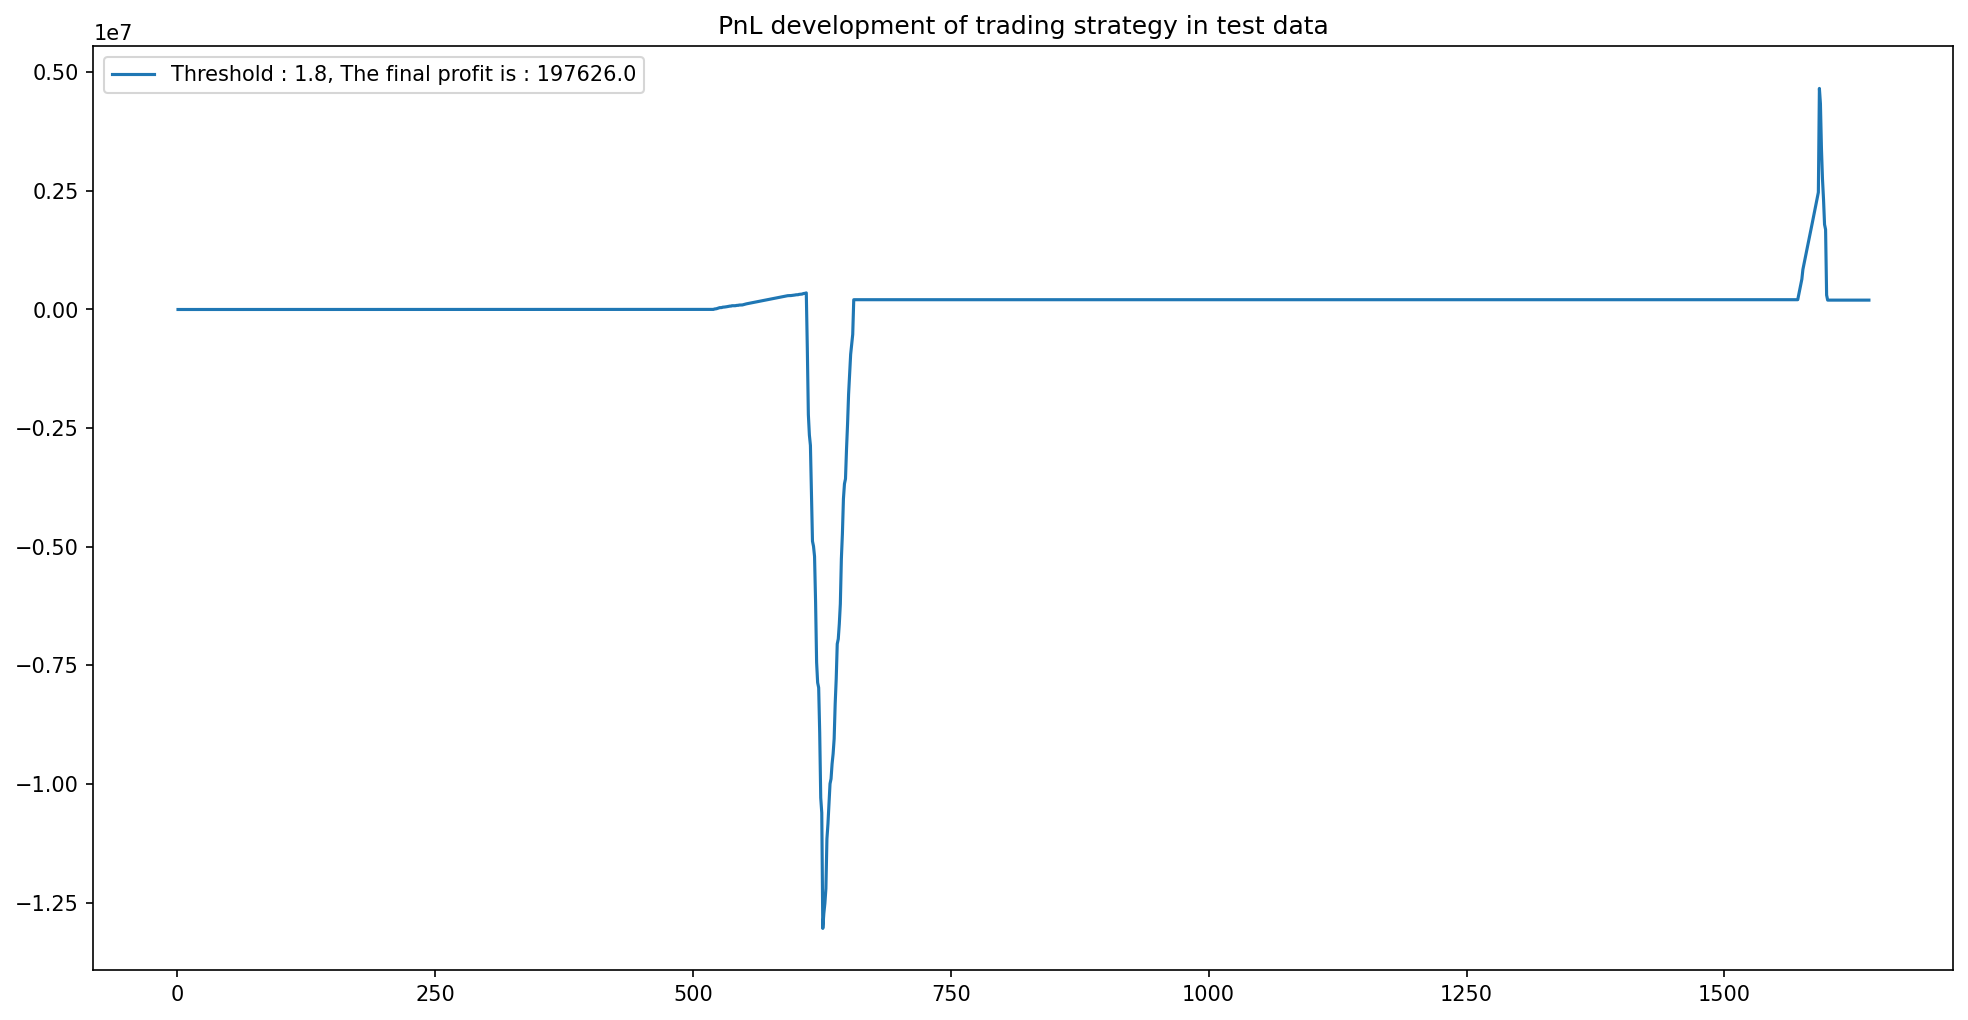

In [511]:
## Plot the profit curve for the test data 
plt.figure(figsize=(16, 8), dpi=150)
plt.plot(range(1, len(test_pnl[1.8])+1), test_pnl[1.8], label = "Threshold : 1.8, The final profit is : " + str(test_pnl[1.8][-1]))
plt.legend()
plt.title("PnL development of trading strategy in test data")

Luckily, the threshold of 1.8 did make $197626 in profit. However, the profit is very small considering the individual prices of X and Y are mostly above $100000. In addition, this feels like a risky strategy for me given the other thresholds mostly lost money in the training data.

One thing I noticed is I might not be selling or buying back the portfolio at the right time. In this strategy, I tend to "neturalise" the portfolio towards (0,0) whenever the z-score does not meet the trading threshold. However, this does not nececcarily indicate convergence. It might be worth it to add a convergence threshold, and only buy back the shorted security and sell the long security once the convergence threshold is met. 


### Strategy 2: Adding convergence threshold

Below are the trading position and pnl calculation functions slightly updated, mostly adding in a convergence threshold and not having to test a wide range of thresholds. 

In [494]:
### Function that adds a covergence threshold.
def trading_positions_2(market_data, beta, avg_zscore, div_threshold, cov_threshold, limit):
    
    positions_x = []
    positions_y = []
        
    current_name = threshold
    current_position_x = 0
    current_position_y = 0
     
    for i in range(len(avg_zscore.index)):
        x_bid, x_ask, y_bid, y_ask, x_bid_vol, x_ask_vol, y_bid_vol, y_ask_vol = market_data[["X_BID", "X_ASK", "Y_BID", "Y_ASK", "X_BID_VOL", "X_ASK_VOL", "Y_BID_VOL", "Y_ASK_VOL"]].iloc[i]
        zscore = avg_zscore.iloc[i]
            
        if zscore > div_threshold: # short X, long Y, X is our main source of profit
            # adjust the hedge ratio with regards to the buying and selling prices
            hedge_ratio = beta * x_bid / y_ask
        
            #max amounts of x can be traded is
            tradable_x = min(limit, x_bid_vol)
            #max amounts of y can be traded is 
            tradable_y = min(limit, y_ask_vol)
            
            max_tradable_x = np.floor(min(tradable_x, tradable_y*hedge_ratio))
            max_tradable_y = np.floor(max_tradable_x/hedge_ratio)
            
            current_position_x = current_position_x - max_tradable_x
             #therefore, the max tradable amount of y is
            current_position_y = current_position_y + max_tradable_y

        elif zscore < -1*div_threshold: # long x, short y
            hedge_ratio = beta * x_ask/y_bid
        
            tradable_x = min(limit, x_ask_vol)
            tradable_y = min(limit, y_bid_vol)
        
            max_tradable_y = np.floor(min(tradable_y, tradable_x/hedge_ratio))
            max_tradable_x = np.floor(max_tradable_y*hedge_ratio)
        
            current_position_x = current_position_x + max_tradable_x
            #therefore, the max tradable amount of y is
            current_position_y = current_position_y - max_tradable_y
            
        elif zscore < cov_threshold and zscore > -1*cov_threshold: 
            if current_position_x > 0:
                current_position_x = current_position_x - min(x_bid_vol, current_position_x)
                current_position_y = current_position_y + min(y_ask_vol, -1*current_position_y)   
            elif current_position_x < 0:
                current_position_x = current_position_x + min(x_ask_vol, -1*current_position_x)
                current_position_y = current_position_y - min(y_bid_vol, current_position_y)
        
        positions_x.append(current_position_x)
        positions_y.append(current_position_y)    
    
    return [positions_x,positions_y]

In [448]:
def calculate_pnl_2(positions_x, positions_y, market_data):
    
    pnl_records = []
    pnl = 0
    
    for j in range(1,len(positions_x)-1):
        
        #determine the amount of x and y traded during the last quarter
        x_traded = positions_x[j] - positions_x[j-1]
        y_traded = positions_y[j] - positions_y[j-1]
        #execute the trade using the current market prices
        
        if x_traded > 0: # x has been the long asset. so y is the short asset
            pnl = pnl - x_traded*market_data["X_ASK"].iloc[j] - y_traded*market_data["Y_BID"].iloc[j]
        elif x_traded < 0: # short x, long y
            pnl = pnl - x_traded*market_data["X_BID"].iloc[j] - y_traded*market_data["Y_ASK"].iloc[j]
            
        pnl_records.append(pnl)
    if positions_x[-1] == 0 and positions_y[-1] == 0:
        pnl_records.append    

    return pnl_records

In [544]:
# Determine trading strategy, setting divergence threshold to 1.8 and convergence threshold to 0.25
test_positions_2 = trading_positions_2(test_data_quarters, beta_test, zscore_test_avg, 1.8, 0.25, 5)
# Calculate profit
test_pnl_2 = calculate_pnl_2(test_positions_2[0], test_positions_2[1], test_data_quarters)

Text(0.5, 1.0, 'PnL development of trading strategy 2 in test data, using a convergence threshold')

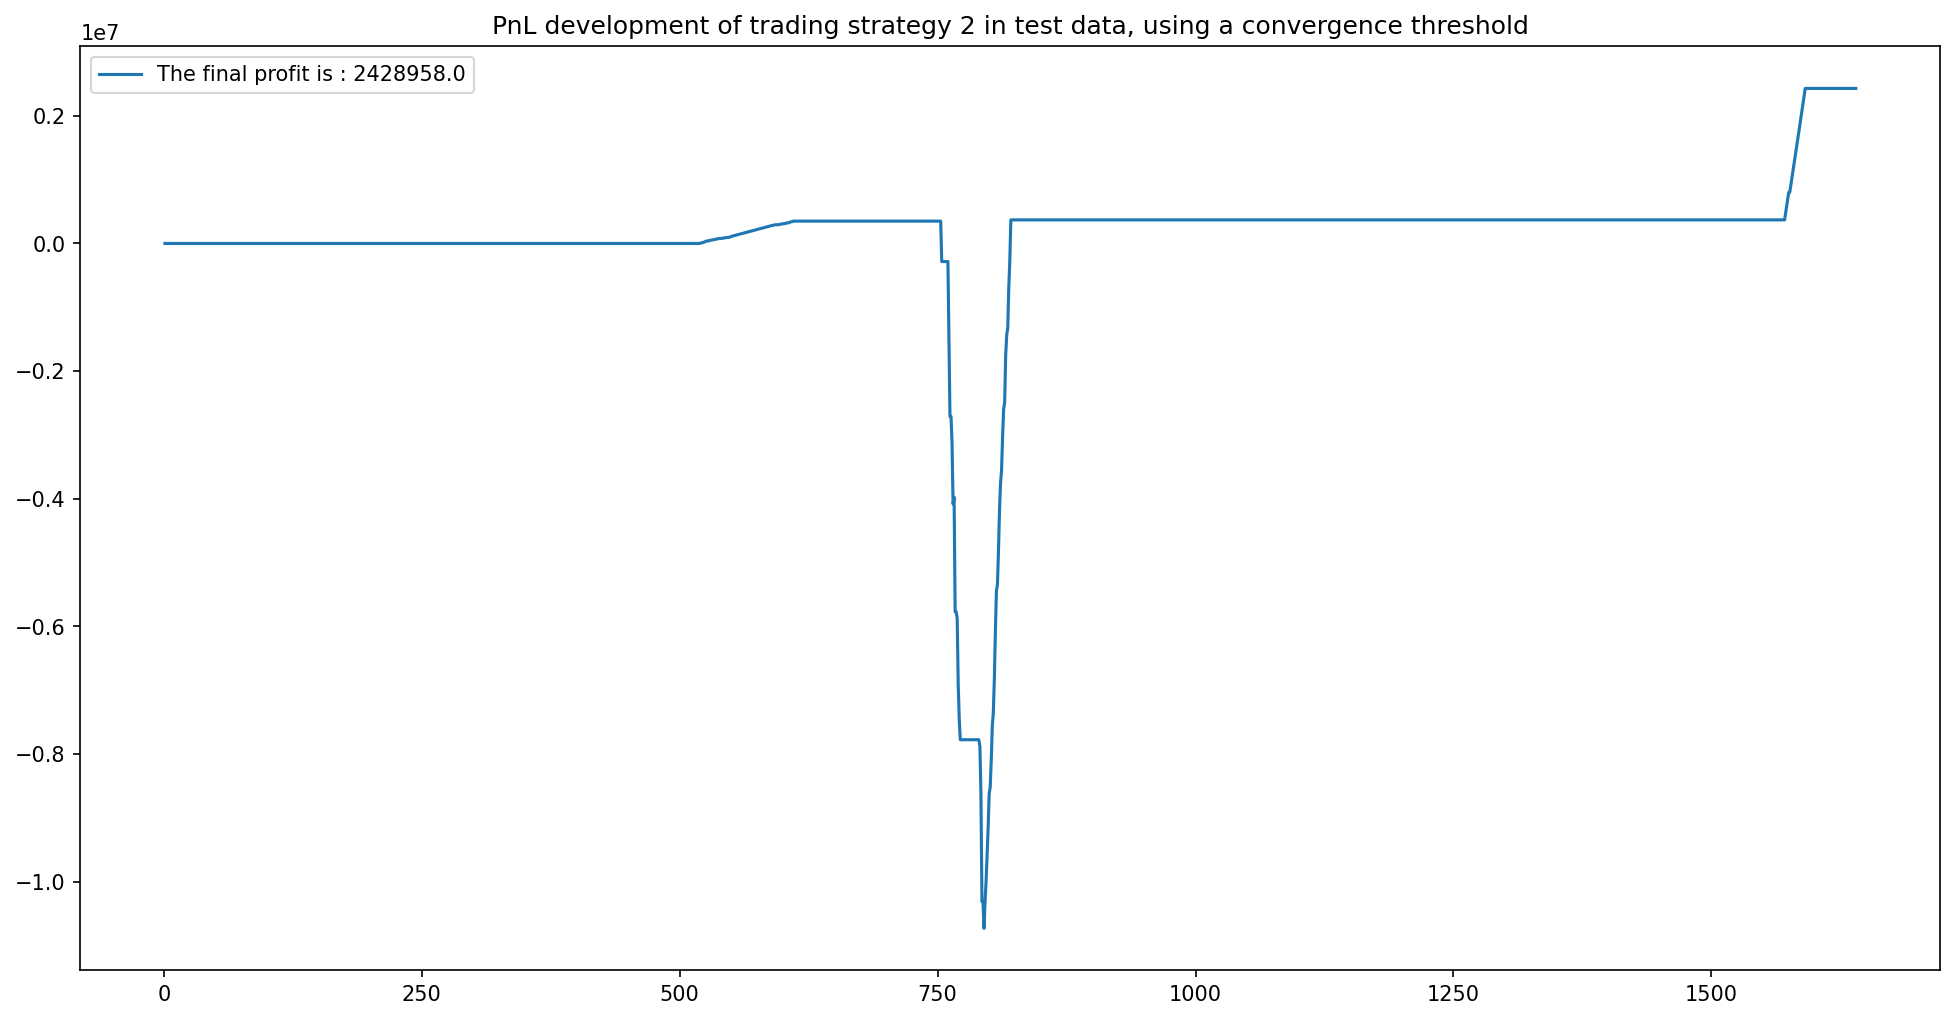

In [545]:
## Plot the profit curve for the test data 
plt.figure(figsize=(16, 8), dpi=150)
plt.plot(range(1, len(test_pnl_2)+1), test_pnl_2, label = "The final profit is : " + str(test_pnl_2[-1]))
plt.legend()
plt.title("PnL development of trading strategy 2 in test data, using a convergence threshold")

Much better. After adding the convergence threshold, we can see the profit is $2428958, which is ten times more than the profit without it.

One thing to worry is if the we have reached a (0,0) portfolio by the end given the convergence threshold.

In [546]:
print(test_positions_2[0][-1], test_positions_2[1][-1])

-45.0 26.0


So no! We have not actually to sell and buy back the portfolio by the end of the trading process, however the previous strategy did.

### Data & Strategy Analysis



- Market suitability for trading:

One specific characteristic I noticed about the data is despite the relationship between X and Y are seemingly linear, the residual of the OLS regression are actually very flutuated. If we plot the Z score of the whole dataset as shown below, just like the training dataset we see that there they are constantly flutuating at larger values, rather than consistenly showing signs of convergence. This also relates to the fact that the two securities are not strongly cointegrated.


Text(0.5, 1.0, 'The Z Score progression for overall data')

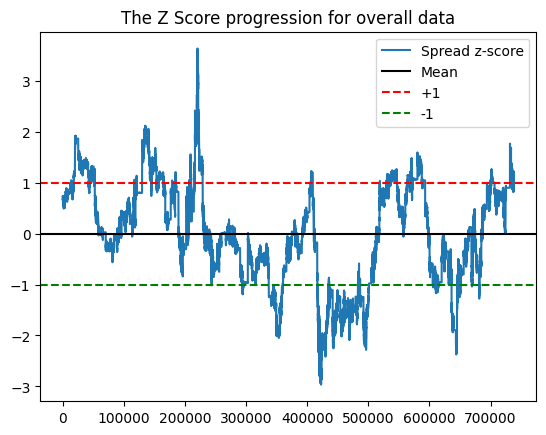

In [553]:
long_run_ols_final = OLS((data["X_MID"]), add_constant((data["Y_MID"])))
long_run_ols_fit_final = long_run_ols_final.fit()
spread_final = long_run_ols_fit_final.resid
zscore_final = zscore(spread_final)
zscore_final.plot()
plt.axhline(zscore_final.mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1'])
plt.title("The Z Score progression for overall data")

Therefore, from my opinion X and Y will be tricky and risky assets to trade, there are certainly some divergence signals we could utilise on, yet there are not very clear signs of covergence.

- Strategy analysis

My strategy have not utilised on the trading opportunities exposed by the securities X and Y. The main problems are:

1. Trading every signal above the threshold is not a good idea for a risky pair like this. My divergence threshold is set quite high, which causes the scenarios that if I do not set a covergence threshold, the strategy is not making enough profit; whereas if I set a convergence threshold, the required buy back and selling volumes cannot be always met provided the convergence threshold is not always met. There definitely could be a better strategy which takes into account of the bid and ask volumes, such as setting a bar on the maximum short and long volumes held in portfolio so they would be able to get cleaned when a convergence sign is received. I did an analysis on the bid ask volume ratios, yet I barely incorporated that in my strategy.

2. The strategy itself is quite simple and probably not intricate enough to utilise on the dataset. A better strategy would be able to observe the trends in the market and adjust the threshold respectively (ideally, since that how many people trade in real life without machine learning). Can hurst's exponent be used as another signal and allow me to do this? I am not sure. 


3. Pair trading is often done with many securities and pairs selection and weighting is an important step. Maybe that will help with the performance? Something outside the scale of this assessment though. 

### *Some Final Self Reflection 

As a first try at an individual quantitative marketing project, I felt decent with my performance, despite I know as a fact that the strategy itself is very rookie and simple. But in a few days of many research, learning these very new concepts and implementing them, I felt this is the best I could and I am at least happy to present it as a quite "complete" process. It definitely was a very exciting and meaningful learning experience, as this is something associated to my degree yet applied to solve problems in a real life scenario, which I am hugely passionate about. 

I want to thank the Optiver team for giving me this opportunity and reading my work till this very last sentence. Regardless of the application itself, any feedback would be much appreciated by myself.

